## DC Metro Analysis using Enriched Data

### Enriched Data Integration: 

Leveraging a pre-processed _enriched dataset that includes Name and Code columns, populated from WMATA API

### Multi-Modal Ingestion: 

Combining different data sources i.e., Bus Ridership (routes/stops) and Rail Summary (temporal flows) into one single source of data for analysis

### Traffic Density Heatmaps: 

Utilizing geospatial KDE (Kernel Density Estimation) and using folium package in python to visualize passenger hotspots
    -- we do this based on bus coordinates and rail network (topology based networks)

### Network Topology Analysis: 

Modeling the metro rail system as a graph to calculate:
    -- centrality metrics
    -- identify critical structural hubs
    -- potential failure bottlenecks

### OD Flow Simulation: 

Synthesizing an Origin-Destination matrix using a Gravity Model to estimate passenger flows between specific station pairs based using entry/exit volumes

### Efficiency Metrics: 

Evaluating route performance by contrasting "Total Volume" against "Utilization Ratios" (Average vs. Max Load) to identify consistently overcrowded transit corridors

In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Data paths
# Bus data
BUS_DATA_PATH = './data/csv_format/BusRdr_Routes_Stops_Time_Periods.csv'

# Update rail pattern to look for enriched files in the new ridership directory
rail_pattern = './data/ridership/Metro_Rail_Ridership_Dataset_Summary_*_enriched.csv'
rail_files = sorted(glob.glob(rail_pattern))

print(f"Setup complete. Found {len(rail_files)} enriched rail data files.")

Setup complete. Found 4 enriched rail data files.


In [2]:
# Ingest Data Functions

def load_bus_data(filepath):
    """Loads bus data and ensures coordinates are numeric."""
    df = pd.read_csv(filepath)
    # Coerce lat/lon to numeric, turning errors into NaNs
    df[['LAT', 'LON']] = df[['LAT', 'LON']].apply(pd.to_numeric, errors='coerce')
    print(f"Bus Data Loaded: {df.shape}")
    return df

def load_rail_data(file_list):
    """Loads and concatenates enriched rail data files."""
    if not file_list:
        print("Warning: No rail files provided to load.")
        return pd.DataFrame()

    # Concatenate all matching CSVs
    df = pd.concat((pd.read_csv(f) for f in file_list), ignore_index=True)

    # Convert service date to datetime object
    if 'SVC_DATE' in df.columns:
        df['SVC_DATE'] = pd.to_datetime(df['SVC_DATE'])

    print(f"Rail Data Loaded: {df.shape}")
    return df

# Execute Loaders
bus_df = load_bus_data(BUS_DATA_PATH)
rail_df = load_rail_data(rail_files)

Bus Data Loaded: (217366, 14)


C:\Users\Varun\AppData\Local\Temp\ipykernel_15044\2898586374.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['SVC_DATE'] = pd.to_datetime(df['SVC_DATE'])


Rail Data Loaded: (4029436, 10)


Top 10 High-Traffic Bus Routes:


,AVG_LOAD,MAX_LOAD
ROUTE_NAME,,
M12,9.796504,14.926190
D80,8.458100,14.519647
D4X,9.903235,14.445377
M20,9.693570,14.244090
D40,9.059127,13.714914
F81,9.863145,13.533858
D50,8.266840,13.319215
F20,8.164268,13.065502
C87,7.051227,12.701737


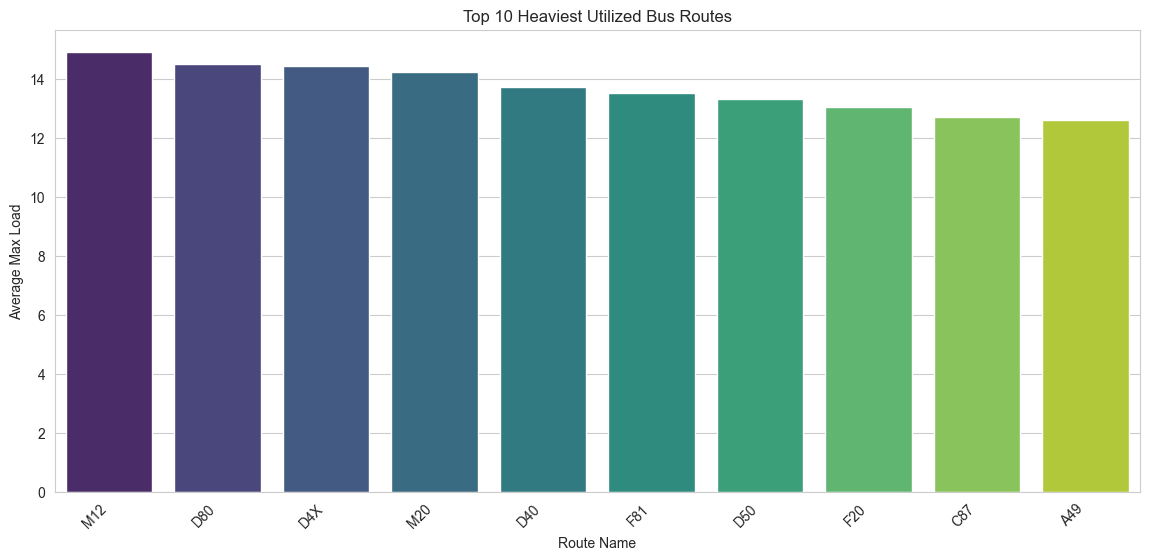

In [3]:
# Analyze Bus Loads

# Aggregation: Identify top routes by load
# We calculate the mean 'AVG_LOAD' and 'MAX_LOAD' across all time periods to find the heaviest routes
route_load = bus_df.groupby('ROUTE_NAME')[['AVG_LOAD', 'MAX_LOAD']].mean() \
                   .sort_values('MAX_LOAD', ascending=False).head(10)

print("Top 10 High-Traffic Bus Routes:")
display(route_load)

# Visualization: Load distribution for top routes
plt.figure(figsize=(14, 6))
sns.barplot(
    x=route_load.index,
    y=route_load['MAX_LOAD'],
    palette='viridis',
    hue=route_load.index,  # Mapped to x to support palette usage without warnings
    legend=False
)

plt.title('Top 10 Heaviest Utilized Bus Routes')
plt.ylabel('Average Max Load')
plt.xlabel('Route Name')
plt.xticks(rotation=45, ha='right')
plt.show()

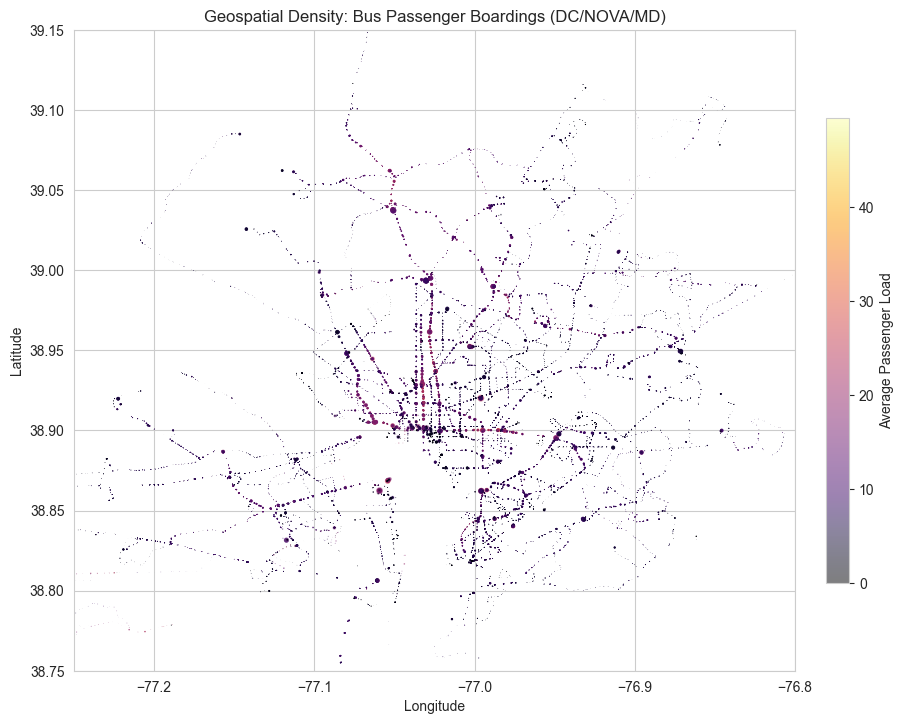

In [4]:
# Geospatial Bus Density

# 1. Data Prep: Filter for valid coordinates
# Removing rows where Lat/Lon are 0 or NaN to ensure map accuracy
geo_bus = bus_df[
    (bus_df['LAT'] != 0) & 
    (bus_df['LON'] != 0)
].dropna(subset=['LAT', 'LON'])

# 2. Visualization Setup
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter Plot parameters
# Size (s) represents total boardings (scaled by 0.05 for readability)
# Color (c) represents the average load on the bus at that location
sc = ax.scatter(
    geo_bus['LON'], 
    geo_bus['LAT'], 
    s=geo_bus['SUM_PASSENGERS_ON'] * 0.05, 
    c=geo_bus['AVG_LOAD'], 
    cmap='inferno', 
    alpha=0.5,
    edgecolors='none'
)

# 3. Map Formatting
ax.set_title('Geospatial Density: Bus Passenger Boardings (DC/NOVA/MD)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')  # Essential for preserving map geometry

# Colorbar to indicate load intensity
plt.colorbar(sc, label='Average Passenger Load', fraction=0.03, pad=0.04)

# 4. Regional Focus (Zoom)
# Hardcoded bounds to focus specifically on the DC Metro Area
ax.set_xlim(-77.25, -76.80)
ax.set_ylim(38.75, 39.15)

plt.show()

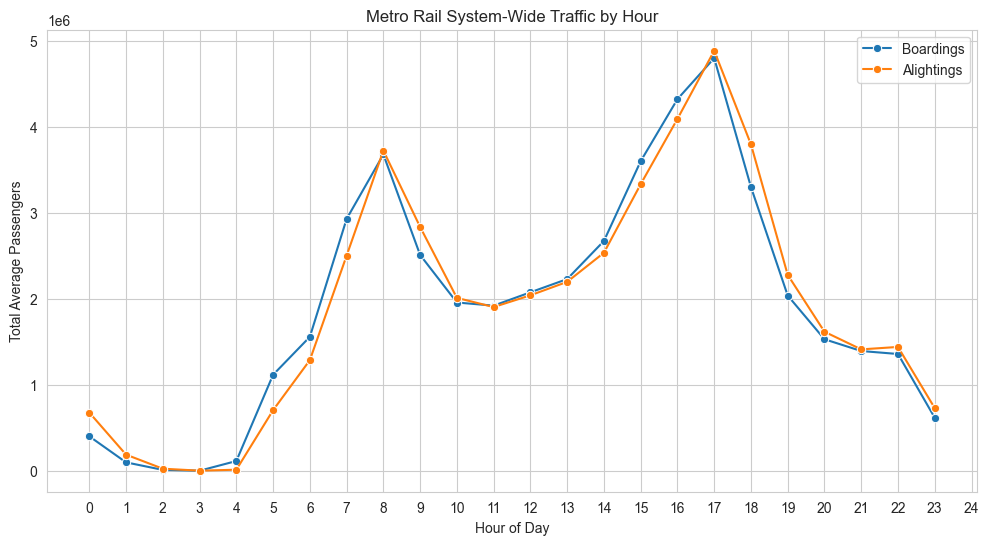


Top 10 Busiest Stations (by Total Boardings):


Name
L'Enfant Plaza          4571829
Metro Center            4223566
Gallery Pl-Chinatown    3168471
Rosslyn                 2433578
Foggy Bottom-GWU        1505617
Pentagon                1195269
Farragut West            994163
Fort Totten              971480
Union Station            884616
East Falls Church        802588
Name: AVG_BOARDINGS, dtype: int64

In [5]:
# Rail Temporal Analysis

# 1. System-Wide Peak Time Analysis
# Aggregating average boardings and alightings by hour to visualize demand curves
hourly_traffic = rail_df.groupby('HOUR')[['AVG_BOARDINGS', 'AVG_ALIGHTINGS']].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_traffic, x='HOUR', y='AVG_BOARDINGS', label='Boardings', marker='o')
sns.lineplot(data=hourly_traffic, x='HOUR', y='AVG_ALIGHTINGS', label='Alightings', marker='o')

plt.title('Metro Rail System-Wide Traffic by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Average Passengers')
plt.xticks(range(0, 25))
plt.legend()
plt.grid(True)
plt.show()

# 2. High-Traffic Station Analysis
# Update: Using the enriched 'Name' column directly to identify stations.
# Grouping by Station Name to find the highest volume boarding locations.
top_stations = rail_df.groupby('Name')['AVG_BOARDINGS'].sum() \
                      .sort_values(ascending=False).head(10)

print("\nTop 10 Busiest Stations (by Total Boardings):")
display(top_stations)

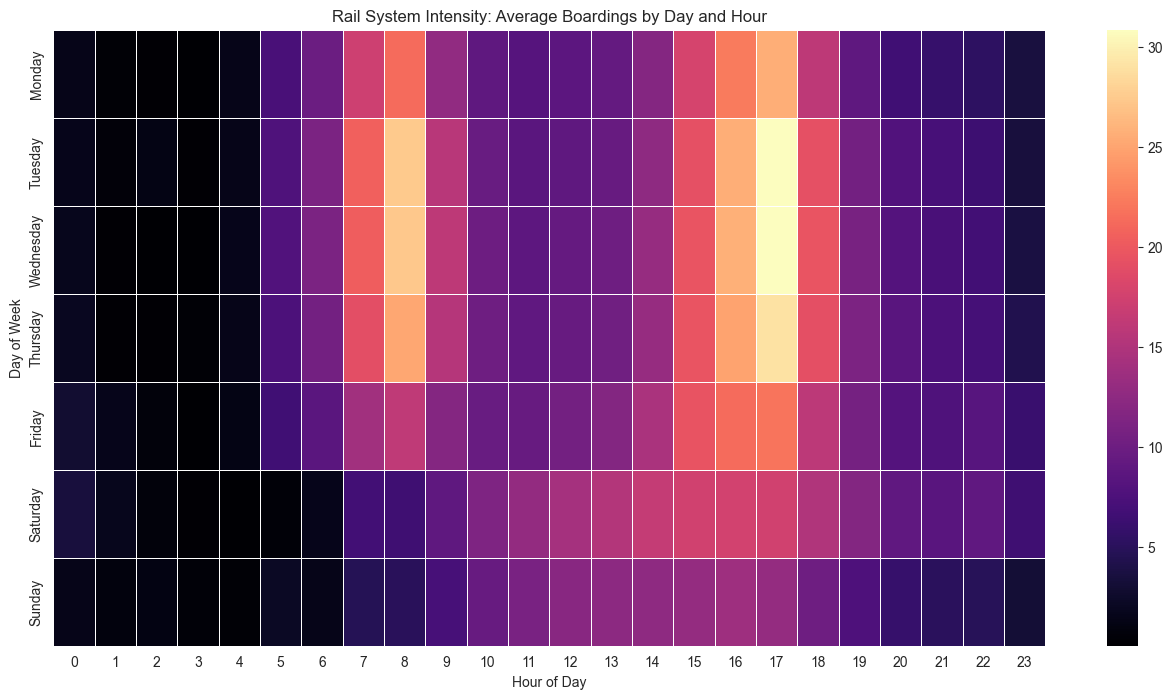

In [6]:
# Weekly Traffic Intensity

# 1. Feature Engineering: Extract Day Names
# We derive the day name from SVC_DATE to ensure consistent formatting for sorting.
rail_df['Day_Name'] = rail_df['SVC_DATE'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 2. Data Transformation: Pivot for Heatmap
# Creating a matrix where rows are Days and columns are Hours.
# Values represent the mean 'AVG_BOARDINGS' to show intensity.
rail_pivot = rail_df.pivot_table(
    index='Day_Name', 
    columns='HOUR', 
    values='AVG_BOARDINGS', 
    aggfunc='mean'
).reindex(days_order)

# 3. Visualization: Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(rail_pivot, cmap='magma', linewidths=.5)

plt.title('Rail System Intensity: Average Boardings by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

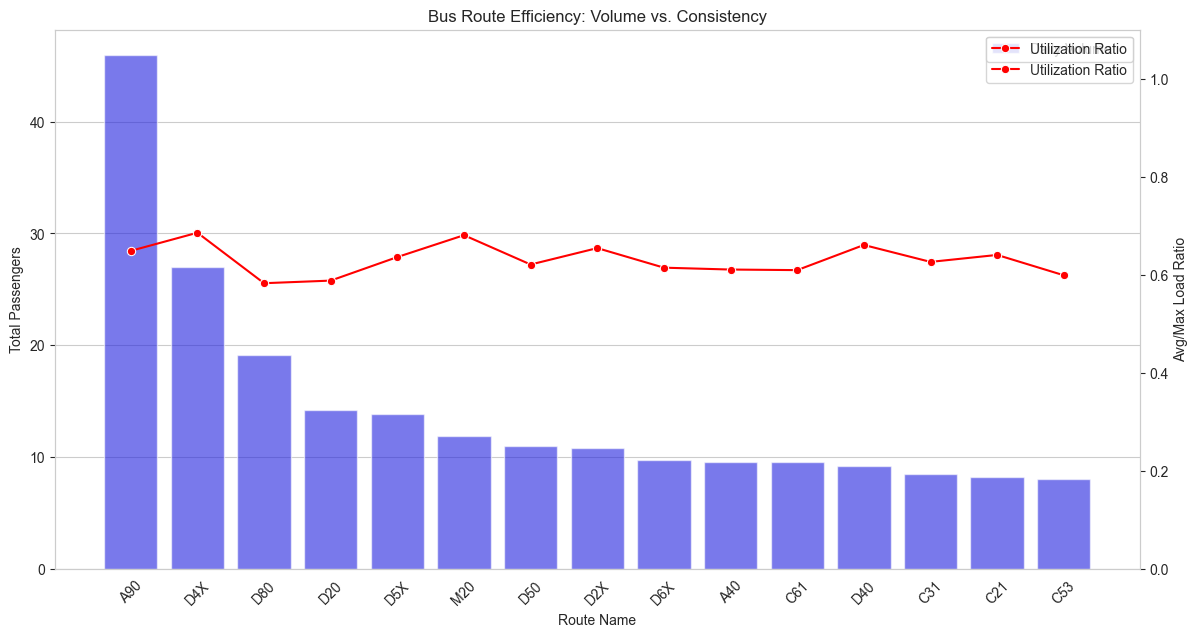

In [7]:
# Bus Efficiency Metrics

# 1. Metric Calculation
# Aggregating key metrics by Route Name
bus_metrics = bus_df.groupby('ROUTE_NAME')[['AVG_LOAD', 'MAX_LOAD', 'SUM_PASSENGERS_ON']].mean()

# Calculate Utilization Ratio (Efficiency): How full is the bus on average compared to its peak?
# We use np.where to avoid DivisionByZero errors if MAX_LOAD is 0
bus_metrics['UTILIZATION_RATIO'] = np.where(
    bus_metrics['MAX_LOAD'] > 0, 
    bus_metrics['AVG_LOAD'] / bus_metrics['MAX_LOAD'], 
    0
)

# Filter: Focus on the top 15 routes by total passenger volume
top_routes = bus_metrics.sort_values('SUM_PASSENGERS_ON', ascending=False).head(15)

# 2. Dual-Axis Visualization
fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary Axis (Bar): Total Passenger Volume
sns.barplot(
    x=top_routes.index, 
    y=top_routes['SUM_PASSENGERS_ON'], 
    alpha=0.6, 
    color='blue', 
    ax=ax1, 
    label='Daily Volume'
)
ax1.set_ylabel('Total Passengers')
ax1.set_xlabel('Route Name')
ax1.tick_params(axis='x', rotation=45)

# Secondary Axis (Line): Efficiency/Utilization Ratio
ax2 = ax1.twinx()
sns.lineplot(
    x=top_routes.index, 
    y=top_routes['UTILIZATION_RATIO'], 
    color='red', 
    marker='o', 
    ax=ax2, 
    label='Utilization Ratio'
)
ax2.set_ylabel('Avg/Max Load Ratio')
ax2.set_ylim(0, 1.1) # Fixed scale for percentage-like ratio
ax2.grid(False) # Disable grid on secondary axis to prevent visual clutter

# Unified Legend Construction
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Bus Route Efficiency: Volume vs. Consistency')
plt.show()

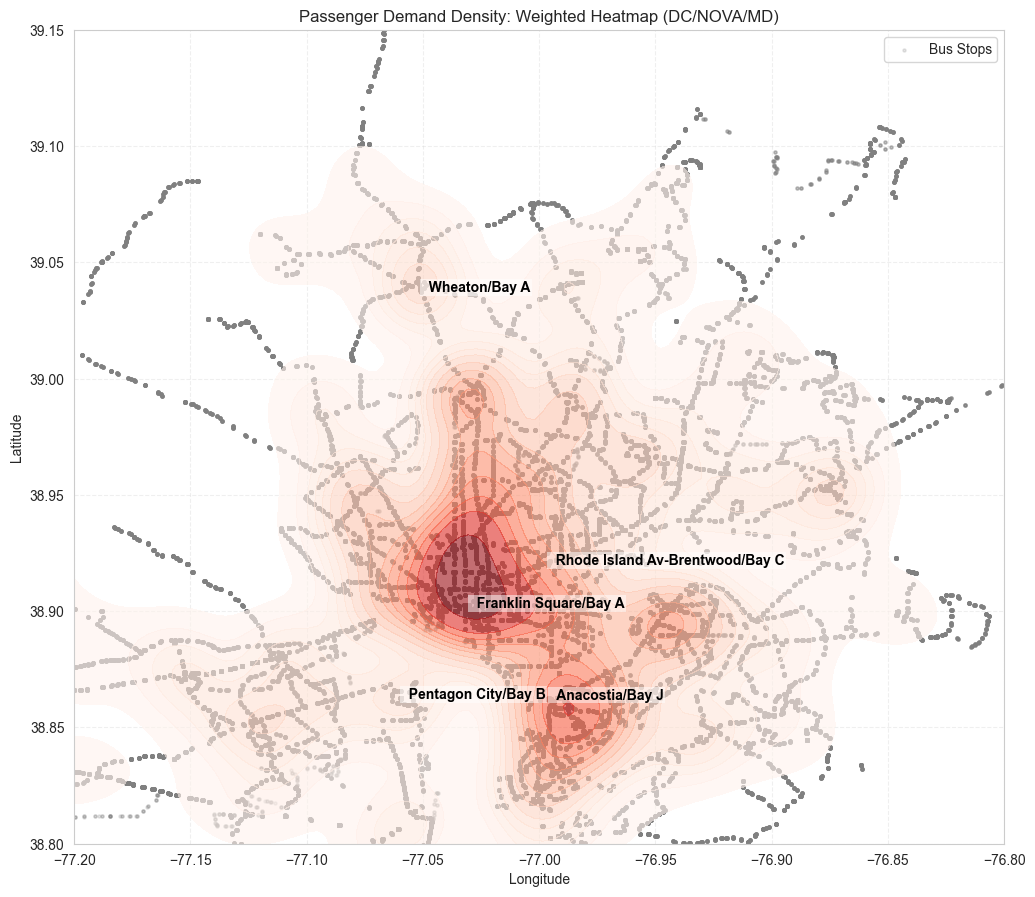

In [8]:
# Demand Density Heatmap

# 1. Data Prep: Filter valid coordinates
# Removing invalid Lat/Lon entries (0 or NaN)
geo_data = bus_df[
    (bus_df['LAT'] != 0) & 
    (bus_df['LON'] != 0)
].dropna(subset=['LAT', 'LON'])

# 2. Setup Map Canvas
fig, ax = plt.subplots(figsize=(12, 12))

# 3. Base Layer: Contextual Stops
# Plotting all stops faintly to provide geographic context for the heatmap
ax.scatter(
    geo_data['LON'], 
    geo_data['LAT'], 
    c='gray', 
    s=5, 
    alpha=0.2, 
    label='Bus Stops'
)

# 4. Density Layer: Passenger Heatmap (KDE)
# Weights are based on 'SUM_PASSENGERS_ON' to visualize volume, not just stop density
sns.kdeplot(
    x=geo_data['LON'], 
    y=geo_data['LAT'], 
    weights=geo_data['SUM_PASSENGERS_ON'], 
    cmap='Reds', 
    fill=True, 
    alpha=0.6, 
    levels=15,    # Number of contour levels
    thresh=0.05,  # Threshold to clip lowest density areas for cleaner look
    ax=ax
)

# 5. Annotation Layer: Top 5 Hotspots
# Identify the top 5 stops by boarding volume to label them on the map
top_stops = geo_data.sort_values('SUM_PASSENGERS_ON', ascending=False).head(5)

for _, row in top_stops.iterrows():
    ax.text(
        row['LON'], 
        row['LAT'], 
        f"  {row['STOP']}", # Adding space for offset
        fontsize=10, 
        fontweight='bold', 
        color='black', 
        ha='left',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1) # Halo effect for readability
    )

# 6. Map Formatting
ax.set_title('Passenger Demand Density: Weighted Heatmap (DC/NOVA/MD)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal') # Crucial: Keeps 1km N-S looking the same as 1km E-W

# Zoom into the DC Metro Area
ax.set_xlim(-77.2, -76.8) 
ax.set_ylim(38.8, 39.15)
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', alpha=0.3)

plt.show()

Top 10 Estimated Passenger Flows (Gravity Model):


,Origin,Destination,Estimated_Trips
5439,Metro Center,L'Enfant Plaza,417578.149191
4857,L'Enfant Plaza,Metro Center,410052.490872
3675,Gallery Pl-Chinatown,L'Enfant Plaza,313262.360750
4839,L'Enfant Plaza,Gallery Pl-Chinatown,310381.138003
5427,Metro Center,Gallery Pl-Chinatown,286737.588285
3681,Gallery Pl-Chinatown,Metro Center,284183.731676
7105,Rosslyn,L'Enfant Plaza,240604.502724
4874,L'Enfant Plaza,Rosslyn,237492.452077
5462,Metro Center,Rosslyn,219401.260600
7111,Rosslyn,Metro Center,218270.351019


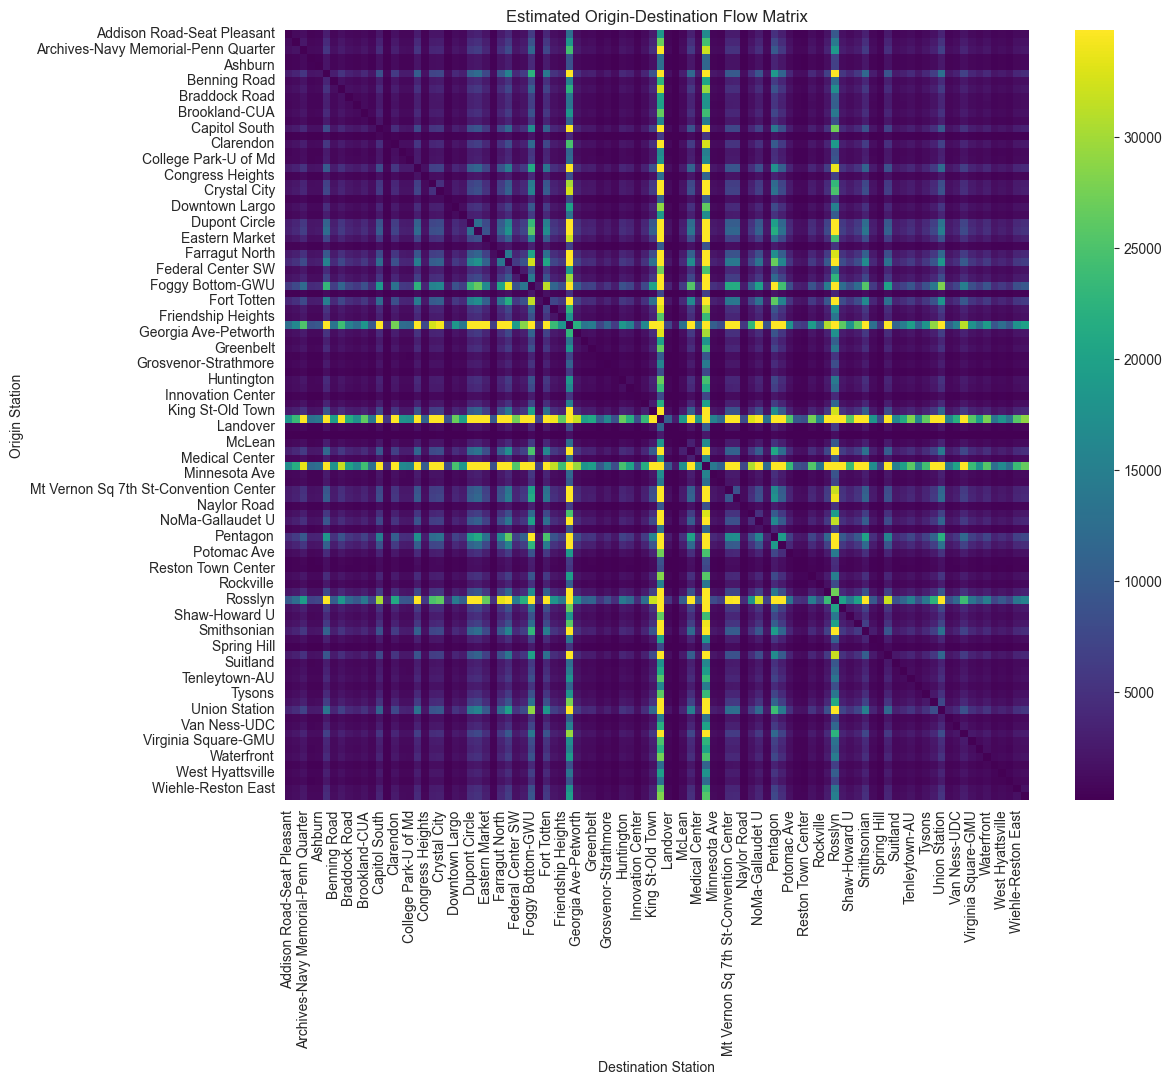

In [9]:
# Synthetic OD Matrix (Gravity Model) - updated with enriched data so we have names now

# 1. Data Aggregation
# Grouping by Station Name to prepare for matrix generation
# We use 'Name' instead of 'STOP_ID' for immediate readability
station_stats = rail_df.groupby('Name')[['AVG_BOARDINGS', 'AVG_ALIGHTINGS']].sum()

# 2. Gravity Model Calculation
# Assumption: Traffic between two stations is proportional to total boardings at Origin
# and total alightings at Destination, normalized by system-wide traffic.
O = station_stats['AVG_BOARDINGS'].values.reshape(-1, 1)  # Origin Vector
D = station_stats['AVG_ALIGHTINGS'].values.reshape(1, -1) # Destination Vector
total_traffic = station_stats['AVG_ALIGHTINGS'].sum()

# Compute Interaction Matrix: (O_i * D_j) / Total_System_Traffic
od_df = pd.DataFrame(
    (O * D) / total_traffic, 
    index=station_stats.index, 
    columns=station_stats.index
)

# Zero out the diagonal (assume no circular trips to same station)
np.fill_diagonal(od_df.values, 0)

# Clean up index names for stacking
od_df.index.name = None
od_df.columns.name = None

# 3. Flatten Matrix to List
od_pairs = od_df.stack().reset_index()
od_pairs.columns = ['Origin', 'Destination', 'Estimated_Trips']

print("Top 10 Estimated Passenger Flows (Gravity Model):")
display(od_pairs.sort_values('Estimated_Trips', ascending=False).head(10))

# 4. Visualization
plt.figure(figsize=(12, 10))

# Using 'robust=True' to handle outliers (super-busy stations) for better color contrast
sns.heatmap(od_df, cmap="viridis", robust=True)

plt.title("Estimated Origin-Destination Flow Matrix")
plt.xlabel("Destination Station")
plt.ylabel("Origin Station")
plt.show()

In [10]:
# Construct WMATA Network Topology
import networkx as nx

def build_wmata_graph():
    """
    Constructs the physical topology of the WMATA rail network.
    
    Note: Since the ridership CSV lacks geospatial sequence data (Stop Order),
    we manually define the station sequences here. 
    """
    G = nx.Graph()
    
    # Define Line Sequences (Physical Tracks ordered by geography)
    # Using the current Silver Line extension configuration (Ashburn)
    lines = {
        'Red': [
            'Shady Grove', 'Rockville', 'Twinbrook', 'North Bethesda', 'Grosvenor-Strathmore', 
            'Medical Center', 'Bethesda', 'Friendship Heights', 'Tenleytown-AU', 'Van Ness-UDC', 
            'Cleveland Park', 'Woodley Park', 'Dupont Circle', 'Farragut North', 'Metro Center', 
            'Gallery Pl-Chinatown', 'Judiciary Square', 'Union Station', 'NoMa-Gallaudet U', 
            'Rhode Island Ave', 'Brookland-CUA', 'Fort Totten', 'Takoma', 'Silver Spring', 
            'Forest Glen', 'Wheaton', 'Glenmont'
        ],
        'Blue': [
            'Franconia-Springfield', 'Van Dorn St', 'King St-Old Town', 'Braddock Rd', 
            'Ronald Reagan Washington National Airport', 'Crystal City', 'Pentagon City', 
            'Pentagon', 'Arlington Cemetery', 'Rosslyn', 'Foggy Bottom-GWU', 'Farragut West', 
            'McPherson Square', 'Metro Center', 'Federal Triangle', 'Smithsonian', "L'Enfant Plaza", 
            'Federal Center SW', 'Capitol South', 'Eastern Market', 'Potomac Ave', 'Stadium-Armory', 
            'Benning Road', 'Capitol Heights', 'Addison Road', 'Morgan Boulevard', 'Downtown Largo'
        ],
        'Orange': [
            'Vienna', 'Dunn Loring', 'West Falls Church', 'East Falls Church', 'Ballston-MU', 
            'Virginia Sq-GMU', 'Clarendon', 'Court House', 'Rosslyn', 'Foggy Bottom-GWU', 
            'Farragut West', 'McPherson Square', 'Metro Center', 'Federal Triangle', 'Smithsonian', 
            "L'Enfant Plaza", 'Federal Center SW', 'Capitol South', 'Eastern Market', 'Potomac Ave', 
            'Stadium-Armory', 'Minnesota Ave', 'Deanwood', 'Cheverly', 'Landover', 'New Carrollton'
        ],
        'Green': [
            'Branch Ave', 'Suitland', 'Naylor Road', 'Southern Avenue', 'Congress Heights', 
            'Anacostia', 'Navy Yard-Ballpark', 'Waterfront', "L'Enfant Plaza", 'Archives', 
            'Gallery Pl-Chinatown', 'Mt Vernon Sq', 'Shaw-Howard U', 'U St', 'Columbia Heights', 
            'Georgia Ave-Petworth', 'Fort Totten', 'West Hyattsville', 'Hyattsville Crossing', 
            'College Park-U of Md', 'Greenbelt'
        ],
        'Yellow': [
            'Huntington', 'Eisenhower Ave', 'King St-Old Town', 'Braddock Rd', 
            'Ronald Reagan Washington National Airport', 'Crystal City', 'Pentagon City', 
            'Pentagon', "L'Enfant Plaza", 'Archives', 'Gallery Pl-Chinatown', 'Mt Vernon Sq'
        ],
        'Silver': [
            'Ashburn', 'Loudoun Gateway', 'Washington Dulles International Airport', 
            'Innovation Center', 'Herndon', 'Reston Town Center', 'Wiehle-Reston East', 
            'Spring Hill', 'Greensboro', 'Tysons', 'McLean', 'East Falls Church', 'Ballston-MU', 
            'Virginia Sq-GMU', 'Clarendon', 'Court House', 'Rosslyn', 'Foggy Bottom-GWU', 
            'Farragut West', 'McPherson Square', 'Metro Center', 'Federal Triangle', 'Smithsonian', 
            "L'Enfant Plaza", 'Federal Center SW', 'Capitol South', 'Eastern Market', 'Potomac Ave', 
            'Stadium-Armory', 'Benning Road', 'Capitol Heights', 'Addison Road', 'Morgan Boulevard', 
            'Downtown Largo'
        ]
    }
    
    # Add Edges (Connections between adjacent stations)
    for line_name, stations in lines.items():
        # Zip creates pairs: (Station_1, Station_2), (Station_2, Station_3)...
        edges = list(zip(stations[:-1], stations[1:]))
        G.add_edges_from(edges, line=line_name)
        
    return G

# 1. Initialize Graph
G_physical = build_wmata_graph()

# 2. Validate against Enriched Data
# Since we manually typed the stations above, we must ensure they match the 'Name' column in our dataframe.
if 'rail_df' in locals():
    valid_names = set(rail_df['Name'].unique())
    graph_nodes = set(G_physical.nodes())
    
    mismatches = graph_nodes - valid_names
    
    print(f"Topology Built: {G_physical.number_of_nodes()} Stations, {G_physical.number_of_edges()} Connections")
    
    if mismatches:
        print(f"\nWARNING: {len(mismatches)} stations in the graph do not match the Enriched Data names:")
        print(mismatches)
        print("Please verify spelling in the 'lines' dictionary above.")
    else:
        print("Validation Successful: All graph nodes match enriched dataset names.")

# 3. Network Analysis (Hub Detection)
print("\nKey Hubs (Highest Degree Centrality):")
# Sort by degree (number of connections)
print(sorted(G_physical.degree, key=lambda x: x[1], reverse=True)[:5])

Topology Built: 97 Stations, 99 Connections

{'Rhode Island Ave', 'U St', 'Braddock Rd', 'Addison Road', 'Archives', 'Woodley Park', 'Van Dorn St', 'Vienna', 'Mt Vernon Sq', 'Eisenhower Ave', 'Virginia Sq-GMU', 'Dunn Loring'}
Please verify spelling in the 'lines' dictionary above.

Key Hubs (Highest Degree Centrality):
[("L'Enfant Plaza", 5), ('Metro Center', 4), ('Gallery Pl-Chinatown', 4), ('Fort Totten', 4), ('King St-Old Town', 3)]


Top 5 Structural Bottlenecks (Critical Fail Points):


,Bottleneck_Score,Hub_Score
L'Enfant Plaza,0.548830,0.052083
Gallery Pl-Chinatown,0.402156,0.041667
Pentagon,0.353947,0.031250
Rosslyn,0.334942,0.031250
Metro Center,0.332822,0.041667


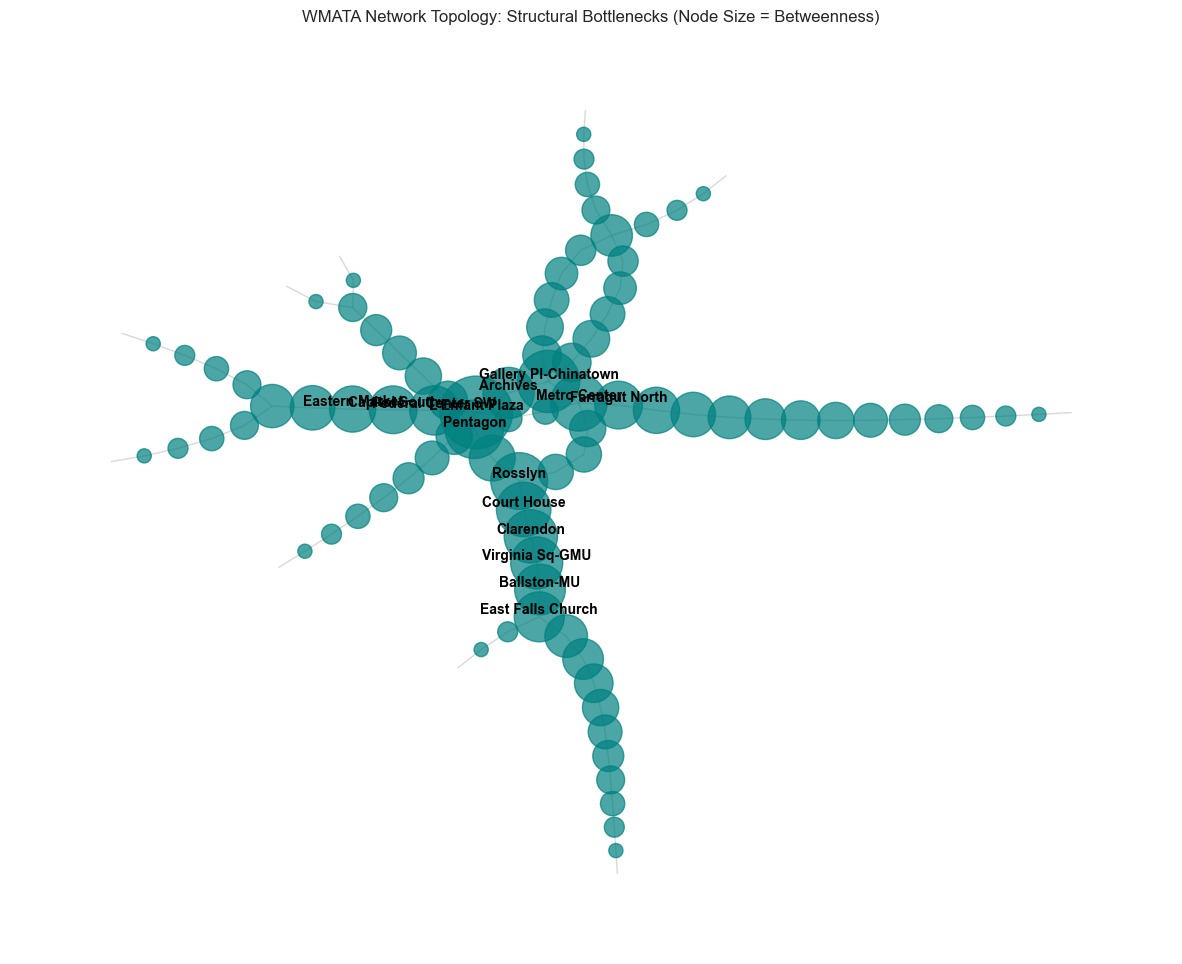

In [11]:
# Network Topology Analysis

# 1. Calculate Centrality Metrics
# Betweenness: Measures how often a station acts as a bridge along the shortest path between two other nodes.
# High betweenness = Critical structural bottleneck.
betweenness = nx.betweenness_centrality(G_physical)

# Degree: Measures the number of direct connections (lines/neighbors) a station has.
# High degree = Major transfer hub.
degree = nx.degree_centrality(G_physical)

# 2. Organize into DataFrame
topology_df = pd.DataFrame({
    'Bottleneck_Score': pd.Series(betweenness),
    'Hub_Score': pd.Series(degree)
})

print("Top 5 Structural Bottlenecks (Critical Fail Points):")
display(topology_df.sort_values('Bottleneck_Score', ascending=False).head(5))

# 3. Visualize Network Structure
plt.figure(figsize=(15, 12))

# Layout: Kamada-Kawai algorithm positions nodes based on "path distance", 
# simulating a physical spring system (good for highlighting structure).
pos = nx.kamada_kawai_layout(G_physical)

# Draw Edges (Tracks)
nx.draw_networkx_edges(G_physical, pos, alpha=0.3, edge_color='gray')

# Draw Nodes (Stations)
# Size is proportional to Betweenness Centrality (Bottleneck Score)
# We map explicitly using G_physical.nodes() to guarantee alignment.
node_sizes = [betweenness[n] * 5000 for n in G_physical.nodes()]

nx.draw_networkx_nodes(
    G_physical, pos, 
    node_size=node_sizes, 
    node_color='teal', 
    alpha=0.7,
    label='Stations'
)

# Labeling: Only label the top 15 most critical stations to maintain readability
top_critical = topology_df.sort_values('Bottleneck_Score', ascending=False).head(15).index
labels = {node: node for node in top_critical}

# Draw labels with a slight vertical offset for clarity
nx.draw_networkx_labels(
    G_physical, pos, 
    labels=labels, 
    font_size=10, 
    font_weight='bold', 
    font_color='black',
    verticalalignment='bottom'
)

plt.title("WMATA Network Topology: Structural Bottlenecks (Node Size = Betweenness)")
plt.axis('off') # Turn off axis numbers for a cleaner look
plt.show()

In [14]:

# Interactive Rail Density Map

import folium
from folium.plugins import HeatMap

# Since the Rail Summary CSV does not contain Lat/Lon, we manually define them here.
station_coords = {
    'Shady Grove': [39.1198, -77.1645], 'Rockville': [39.0842, -77.1464],
    'Glenmont': [39.0617, -77.0536], 'Silver Spring': [38.9938, -77.0313],
    'Greenbelt': [39.0110, -76.9113], 'College Park-U of Md': [38.9785, -76.9284],
    'New Carrollton': [38.9483, -76.8715], 'Downtown Largo': [38.9008, -76.8475],
    'Branch Ave': [38.8264, -76.9114], 'Huntington': [38.7938, -77.0755],
    'Franconia-Springfield': [38.7661, -77.1670], 'Vienna': [38.8778, -77.2721],
    'Ashburn': [39.0301, -77.4913], 'Washington Dulles International Airport': [38.9478, -77.4463],
    'Metro Center': [38.8983, -77.0280], "L'Enfant Plaza": [38.8847, -77.0219],
    'Rosslyn': [38.8965, -77.0718], 'Pentagon': [38.8693, -77.0540],
    'Gallery Pl-Chinatown': [38.8983, -77.0218], 'Union Station': [38.8977, -77.0058],
    'Fort Totten': [38.9517, -77.0021], 'King St-Old Town': [38.8064, -77.0611],
    'Crystal City': [38.8577, -77.0505], 'Farragut North': [38.9034, -77.0397],
    'Dupont Circle': [38.9096, -77.0434], 'Woodley Park': [38.9249, -77.0524],
    'Bethesda': [38.9842, -77.0944], 'Tenleytown-AU': [38.9478, -77.0796],
    'Columbia Heights': [38.9288, -77.0327], 'U St': [38.9168, -77.0281],
    'Tysons': [38.9208, -77.2323], 'Reston Town Center': [38.9527, -77.3603]
}

def generate_interactive_heatmap(od_df, coords):
    """
    Generates a Folium heatmap based on passenger volume.
    Input: od_df (DataFrame with 'Origin', 'Destination', 'Estimated_Trips')
    """
    # 1. Calculate Activity (Total Traffic = Boardings + Alightings)
    activity = {}
    
    if od_df is not None:
        # Grouping by Name directly (Enriched Data Benefit)
        out_traffic = od_df.groupby('Origin')['Estimated_Trips'].sum()
        in_traffic = od_df.groupby('Destination')['Estimated_Trips'].sum()
        
        # Match Traffic Data to Known Coordinates
        for name in coords.keys():
            total = out_traffic.get(name, 0) + in_traffic.get(name, 0)
            
            if total > 0:
                activity[name] = total
                
    # Debug: Check data matches
    print(f"Matched Stations with Activity > 0: {len(activity)}")
    if not activity:
        print("CRITICAL: No stations matched! Check spelling in 'station_coords' vs 'rail_df'.")

    # 2. Prepare Data for Folium (Lat, Lon, Normalized Intensity)
    # Normalize by the busiest station to scale opacity (0.0 to 1.0)
    max_val = max(activity.values()) if activity else 1
    
    heat_data = [
        [coords[station][0], coords[station][1], activity.get(station, 0)/max_val]
        for station in activity
    ]

    # 3. Initialize Map (Centered on DC)
    dc_map = folium.Map(location=[38.9072, -77.0369], zoom_start=11, tiles='cartodbpositron')

    # 4. Add Heatmap Layer
    HeatMap(heat_data, radius=18, blur=12, max_zoom=1).add_to(dc_map)
    
    # 5. Add Detail Markers (Hover for info)
    for station, coord in coords.items():
        if station in activity:
            val = int(activity[station])
            
            # Formatting: Red for busy hubs, Blue for local stops
            color = 'red' if val > (max_val * 0.5) else 'blue'
            
            folium.CircleMarker(
                location=coord,
                radius=6 if val > 0 else 2,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"<b>{station}</b><br>Activity: {val} trips"
            ).add_to(dc_map)

    return dc_map

# Run Visualization
# Note: We pass 'od_pairs' (created in the previous cell) and our coord dictionary
rail_map = generate_interactive_heatmap(od_pairs, station_coords)
# display(rail_map)

rail_map.save("rail_network_heatmap.html")

Matched Stations with Activity > 0: 29
